In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import pylab
import seaborn as sns
import scipy.stats as stats 
from pandas_datareader import data as pdr
import plotly.offline as pyo
import yfinance as yfin
yfin.pdr_override()
pyo.init_notebook_mode(connected=True)
pd.options.plotting.backend = 'plotly'

In [2]:
end = dt.datetime.today()
start = dt.datetime(1989, 1, 1)
df = pdr.get_data_yahoo(['MSFT'], start, end)
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1989-01-03,0.371528,0.373264,0.366319,0.372396,0.232337,51825600
1989-01-04,0.371528,0.381076,0.371528,0.376736,0.235045,53899200
1989-01-05,0.380208,0.380208,0.369792,0.370660,0.231254,47246400
1989-01-06,0.371528,0.373264,0.368056,0.368056,0.229629,59054400
1989-01-09,0.368056,0.369792,0.361979,0.364583,0.227463,46008000


Simple vs Log Returns

Firstly one period simple returns
Rt=Pt–Pt−1Pt−1=PtPt−1–1
1+Rt=PtPt−1
Calculate Daily Simple Returns

In [3]:
simple_returns = df.Close.pct_change().dropna()
simple_returns

Date
1989-01-04    0.011654
1989-01-05   -0.016128
1989-01-06   -0.007025
1989-01-09   -0.009436
1989-01-10   -0.009523
                ...   
2023-03-31    0.014962
2023-04-03   -0.003711
2023-04-04   -0.000174
2023-04-05   -0.009889
2023-04-06    0.025533
Name: Close, Length: 8632, dtype: float64

For multi-period k returns

1+Rt(k)=PtPt−1Pt−1Pt−2…Pt−k+1Pt−k=PtPt−k
1+Rt(k)=(1+Rt)(1+Rt−1)…(1+Rt−k+1)
1+Rt(k)=∏k−1i=0(1+Rt−i)
Plot financial data and look at first and last share prices

In [4]:
df.Close.plot().update_layout(autosize=False, width=500, height=300).show(renderer="colab")

In [5]:
print('First', df.Close[0], 'Last', df.Close[-1])

First 0.37239599227905273 Last 291.6000061035156


Use simple returns & attempt to compute final price from starting price over time horizon

In [6]:
simple_returns.mean()

0.0009770582709322294

In [7]:
df.Close[0]*(1+simple_returns.mean())**len(simple_returns)

1706.2477536977044

In [8]:
df.Close[0]*np.prod([(1+Rt) for Rt in simple_returns])

291.6000061035149

Log Returns

Now onto one period log returns:
rt=ln(1+Rt)
K-period log returns:
rt(k)=ln(1+Rt(k))=ln[(1+Rt)(1+Rt−1)…(1+Rt−k+1)]
rt(k)=ln(1+Rt(k))=ln(1+Rt)+ln(1+Rt−1)+…+ln(1+Rt−k+1)
rt(k)=ln(1+Rt(k))=rt+rt−1+…+rt−k+1=ln(Pt)–ln(Pt−k)
Compute log returns in python

In [9]:
log_returns = np.log(df.Close / df.Close.shift(1)).dropna()
log_returns

Date
1989-01-04    0.011587
1989-01-05   -0.016259
1989-01-06   -0.007050
1989-01-09   -0.009481
1989-01-10   -0.009569
                ...   
2023-03-31    0.014851
2023-04-03   -0.003718
2023-04-04   -0.000174
2023-04-05   -0.009938
2023-04-06    0.025212
Name: Close, Length: 8632, dtype: float64

In [10]:
log_returns.mean()

0.0007719161858867307

In [11]:
df.Close[0] * np.exp(len(log_returns) * log_returns.mean())

291.6000061035147

AGAIN, THE MAIN REASON!
If we want to model returns using the normal distribution!
 – SIMPLE RETURNS: The product of normally distribution variables is NOT normally distributed
 – LOG RETURNS: The sum of normally distributed variables follows a normal distribution
Also the log distribution bounds our stock price at 0. Which is a nice property to have and is consistent with reality.

Histogram of log returns

In [12]:
log_returns.plot(kind='hist').update_layout(autosize=False,width=500,height=300).show(renderer="colab")

Is normality a good assumption for financial data?

The assumption that prices or more accurately log returns are normally distributed?

In [13]:
log_returns_sorted = log_returns.tolist()
log_returns_sorted.sort()
worst = log_returns_sorted[0]
best = log_returns_sorted[-1]

std_worst = (worst - log_returns.mean())/log_returns.std()
std_best = (best - log_returns.mean())/log_returns.std()

print('Assuming price is normally distributed: ')
print(' Standard dev. worst %.2f and best %.2f' %(std_worst, std_best))
print(' Probability of worst %.13f and best %.13f' %(stats.norm(0, 1).pdf(std_worst), stats.norm(0, 1).pdf(std_best)))

Assuming price is normally distributed: 
 Standard dev. worst -8.42 and best 8.79
 Probability of worst 0.0000000000000 and best 0.0000000000000


Testing for Normality

https://towardsdatascience.com/normality-tests-in-python-31e04aa4f411
Q-Q or Quantile-Quantile Plots

It plots two sets of quantiles against one another i.e. theoretical quantiles against the actual quantiles of the variable.

Q-Q Plot


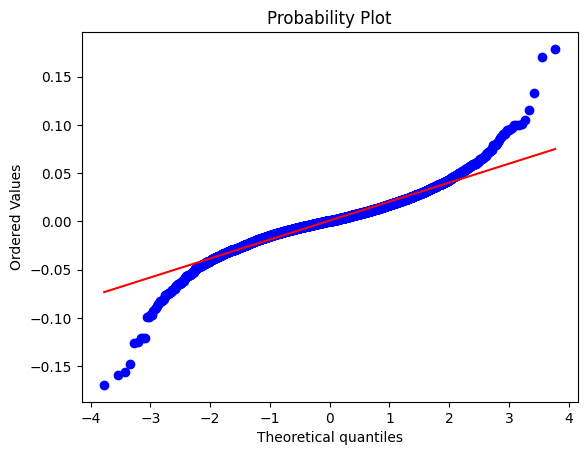

In [14]:
stats.probplot(log_returns, dist='norm', plot=pylab)
print('Q-Q Plot')

Box Plots

Box Plot also know as a box and whisker plot is another way to visualize the normality of a variable. It displays the distribution of data based on a five-number summary i.e. minimum, first quartile (Q1), median (Q2), third quartile (Q3) and maximum.

In [15]:
log_returns.plot(kind = 'box').update_layout(autosize=False,width=350,height=500).show(renderer="colab")

Hypothesis Testing / Statistical Inference ?

Why would you do it? – it can give a more objective answer!
Kolmogorov Smirnov test

The Kolmogorov Smirnov test computes the distances between the empirical distribution and the theoretical distribution and defines the test statistic as the supremum of the set of those distances.

The Test Statistic of the KS Test is the Kolmogorov Smirnov Statistic, which follows a Kolmogorov distribution if the null hypothesis is true. If the observed data perfectly follow a normal distribution, the value of the KS statistic will be 0. The P-Value is used to decide whether the difference is large enough to reject the null hypothesis:

The advantage of this is that the same approach can be used for comparing any distribution, not necessary the normal distribution only.

    Do not forget to assign arguments mean and standard deviation! (this was reminded by a subscriber – thanks)

In [16]:
ks_statistic, p_value = stats.kstest(log_returns, 'norm', args = (log_returns.mean(), log_returns.std()))
print(ks_statistic, p_value)
if p_value > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

0.06455230616749655 1.0265396997747556e-31
Probably not Gaussian


Shapiro Wilk test

The Shapiro Wilk test is the most powerful test when testing for a normal distribution. It has been developed specifically for the normal distribution and it cannot be used for testing against other distributions like for example the KS test.

In [17]:
sw_stat, p = stats.shapiro(log_returns)
print('stat=%.3f, p=%.3f' % (sw_stat, p))
if p_value > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

stat=0.943, p=0.000
Probably not Gaussian


C:\Users\pauli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\stats\_morestats.py:1816: UserWarning:

p-value may not be accurate for N > 5000.

